In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import Trainer_v03b2 as TP
import h5py

## Network structures

In [10]:
m1 = TP.ImageEncoder(latent_dim=256)
summary(m1, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ImageEncoder                             [4, 512]                  --
├─Sequential: 1-1                        [1, 16, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         160
│    └─Identity: 2-2                     [1, 16, 128, 128]         --
│    └─LeakyReLU: 2-3                    [1, 16, 128, 128]         --
├─Sequential: 1-2                        [1, 32, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 128, 128]         4,640
│    └─Identity: 2-5                     [1, 32, 128, 128]         --
│    └─LeakyReLU: 2-6                    [1, 32, 128, 128]         --
│    └─MaxPool2d: 2-7                    [1, 32, 64, 64]           --
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 64, 64, 64]           18,496
│    └─Identity: 2-9                     [1, 64, 64, 64]           --
│    └─

In [8]:
m2 = TP.ImageDecoder(latent_dim=256)
summary(m2, input_size=(1, 512))

Layer (type:depth-idx)                   Output Shape              Param #
ImageDecoder                             [1, 1, 128, 128]          --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 4096]                 1,052,672
│    └─ReLU: 2-2                         [1, 4096]                 --
│    └─Linear: 2-3                       [1, 256]                  1,048,832
│    └─ReLU: 2-4                         [1, 256]                  --
├─Sequential: 1-2                        [1, 128, 4, 4]            --
│    └─ConvTranspose2d: 2-5              [1, 128, 4, 4]            524,416
│    └─Identity: 2-6                     [1, 128, 4, 4]            --
│    └─LeakyReLU: 2-7                    [1, 128, 4, 4]            --
├─Sequential: 1-3                        [1, 64, 8, 8]             --
│    └─ConvTranspose2d: 2-8              [1, 64, 8, 8]             131,136
│    └─Identity: 2-9                     [1, 64, 8, 8]       

In [5]:
m3 = TP.CsiEncoder()
summary(m3, input_size=(2, 90, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CsiEncoder                               [1, 256]                  353,374,464
├─Sequential: 1-1                        [1, 16, 30, 98]           --
│    └─Conv2d: 2-1                       [1, 16, 30, 98]           160
│    └─LeakyReLU: 2-2                    [1, 16, 30, 98]           --
├─Sequential: 1-2                        [1, 32, 14, 48]           --
│    └─Conv2d: 2-3                       [1, 32, 14, 48]           4,640
│    └─LeakyReLU: 2-4                    [1, 32, 14, 48]           --
├─Sequential: 1-3                        [1, 64, 12, 46]           --
│    └─Conv2d: 2-5                       [1, 64, 12, 46]           18,496
│    └─LeakyReLU: 2-6                    [1, 64, 12, 46]           --
├─Sequential: 1-4                        [1, 128, 10, 44]          --
│    └─Conv2d: 2-7                       [1, 128, 10, 44]          73,856
│    └─LeakyReLU: 2-8                    [1, 128, 10, 44]       

## Loader

In [2]:
class Shapes3D(Data.Dataset):
    def __init__(self, datadir, transform=None, number=0):
        self.seeds = None
        self.transform = transform
        self.data = self.load_data(datadir, number)

    def __getitem__(self, index):
        if self.transform:
            image = self.transform(self.data['x'][index])
        else:
            image = self.data['x'][index]

        return image, self.data['y'][index]

    def __len__(self):
        return self.data['y'].shape[0]

    def load_data(self, datadir, number):
        data = h5py.File(datadir, 'r')
        x = data['images']
        y = data['labels']

        if number != 0:
            picked = np.random.choice(list(range(len(x))), size=number, replace=False)
            picked.sort()
            self.seeds = picked
            x = x[picked]
            y = y[picked]

        return {'x': x, 'y': y}

In [3]:
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([128,128]),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                      #          transforms.Normalize((0.5, ), (0.5, ))
])

datadir = '../Dataset/3DShapes/3dshapes.h5'
mydata = Shapes3D(datadir, transform=transform, number=0)

train_size = int(len(mydata) * 0.0003)
valid_size = int(len(mydata) * 0.0001)
test_size = int(len(mydata)) - train_size - valid_size
print(train_size, valid_size, test_size)

train_loader, valid_loader, test_loader = TP.split_loader(mydata, train_size, valid_size, test_size, 64)

144 48 479808
144 48 479808


In [4]:
# Hyperparameters
t_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-5, criterion=nn.SmoothL1Loss(reduction="sum"))
s_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-5, criterion=nn.SmoothL1Loss())

In [5]:
# Model and Loss
imgencoder = TP.ImageEncoder(batchnorm=False, latent_dim=8).to(t_args.device)
imgdecoder = TP.ImageDecoder(batchnorm=False, latent_dim=8, active_func=nn.LeakyReLU()).to(t_args.device)
csiencoder = TP.CsiEncoder(batchnorm=False, latent_dim=256).to(t_args.device)
optimizer = torch.optim.Adam

trainer = TP.TrainerVariationalTS(img_encoder=imgencoder, img_decoder=imgdecoder, csi_encoder=csiencoder,
                                   teacher_args=t_args, student_args=s_args, 
                                   train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                                   optimizer=optimizer, temperature=1, latent_dim=8,kl_weight=0.25)

In [ ]:
# Load from checkpoints
trainer.toal_epochs=0
imgencoder.load_state_dict(torch.load('../Models/ImgEn_Model_v02a1_ImgEn_Fc_0307_tep1200.pth'))
imgdecoder.load_state_dict(torch.load('../Models/ImgDe_Model_v02a1_ImgDe_FC_0307_tep1200.pth'))
csiencoder.load_state_dict(torch.load('../Models/CSIEn_Model_v02a1_CsiEn_Last_0307_tep1200_sep700.pth'))

In [10]:
# When changing learning rate
t_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-6, criterion=nn.SmoothL1Loss(reduction="sum"))
s_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-7, criterion=nn.SmoothL1Loss())
trainer.teacher_args = t_args
trainer.student_args = s_args

In [6]:
# Training and Saving
trainer.train_teacher() 

Teacher: epoch=99/100,1/2of train, loss=1369.6939697265625
Total training time: 4867.259031057358 sec


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


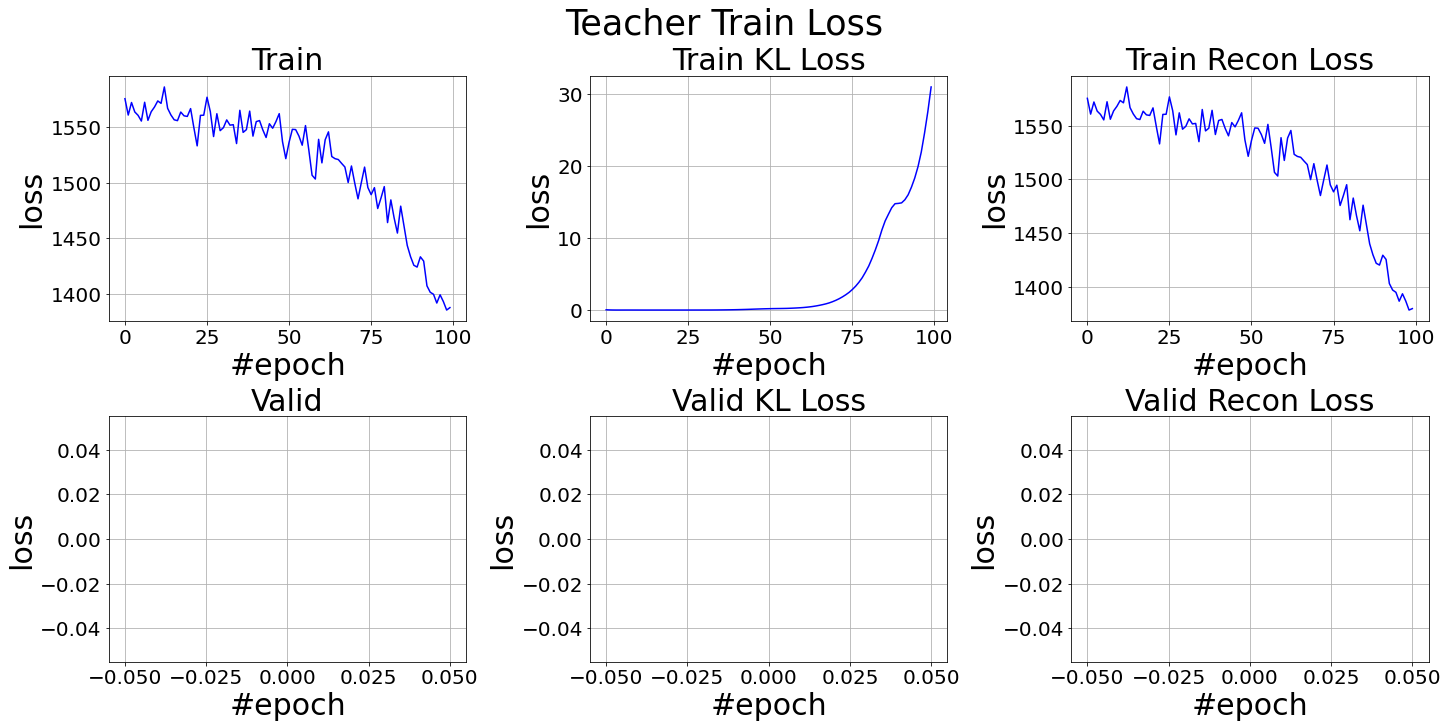

In [7]:
# Plot loss curves
%matplotlib inline
trainer.plot_teacher_loss()

In [8]:
  #=====================test============================
trainer.test_teacher(mode='train')

Teacher: 0/2of test, loss=1358.9757080078125

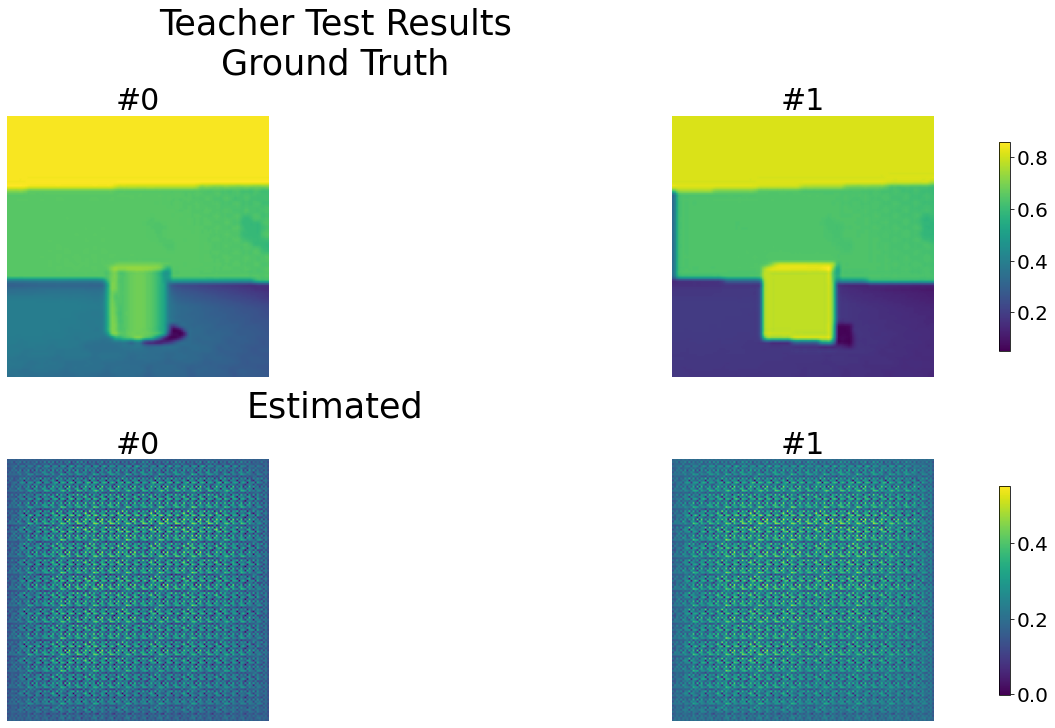

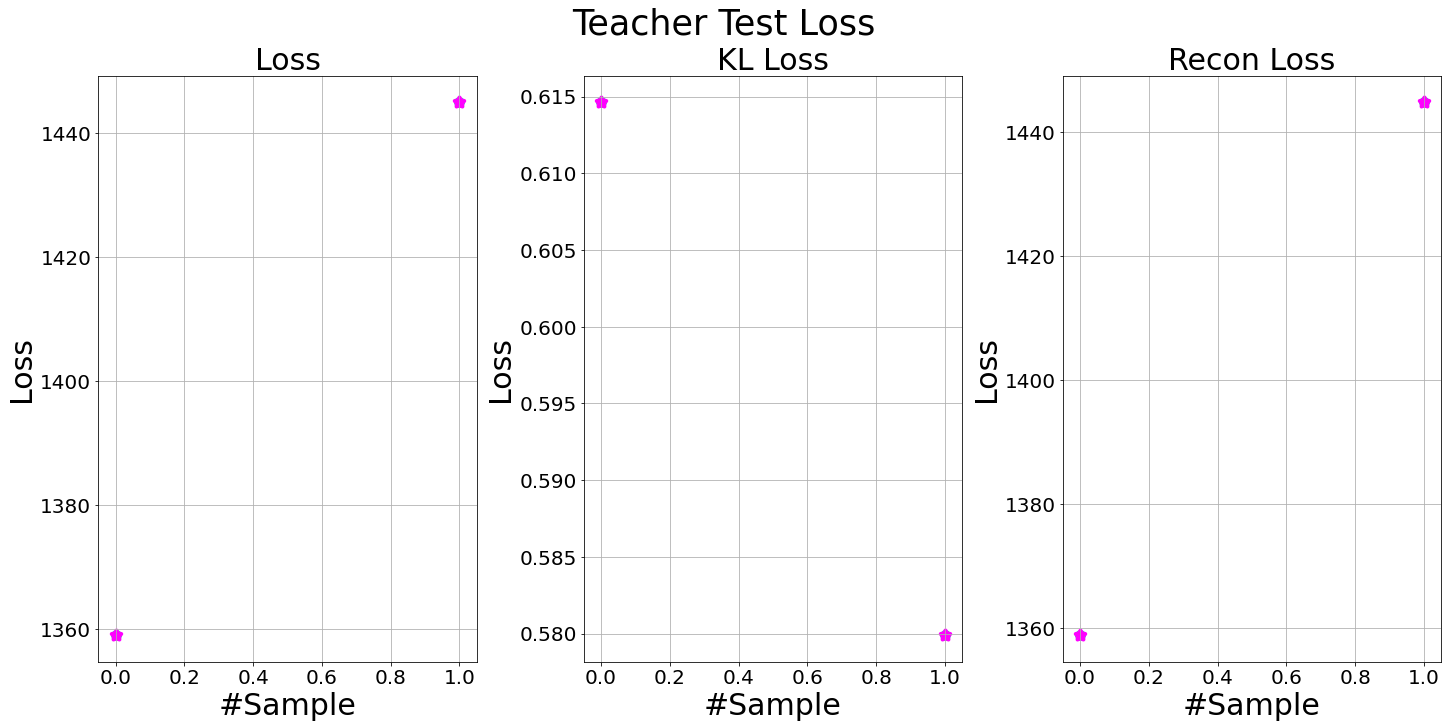

In [11]:
%matplotlib inline
trainer.plot_teacher_test(select_num=2)

In [ ]:
# Training and Saving
trainer.train_student()

In [ ]:
# Plot loss curves
%matplotlib inline
trainer.plot_student_loss()

In [ ]:
  #=====================test============================
trainer.test_student()

In [ ]:
# Final outputs
%matplotlib inline
trainer.plot_student_test()

In [33]:
notion = '_0307'
torch.save(trainer.csi_encoder.state_dict(),
           '../Models/CSIEn_' + str(trainer.csi_encoder) + notion + '_tep' + str(trainer.teacher_epochs) +
           '_sep' + str(trainer.student_epochs) + '.pth')

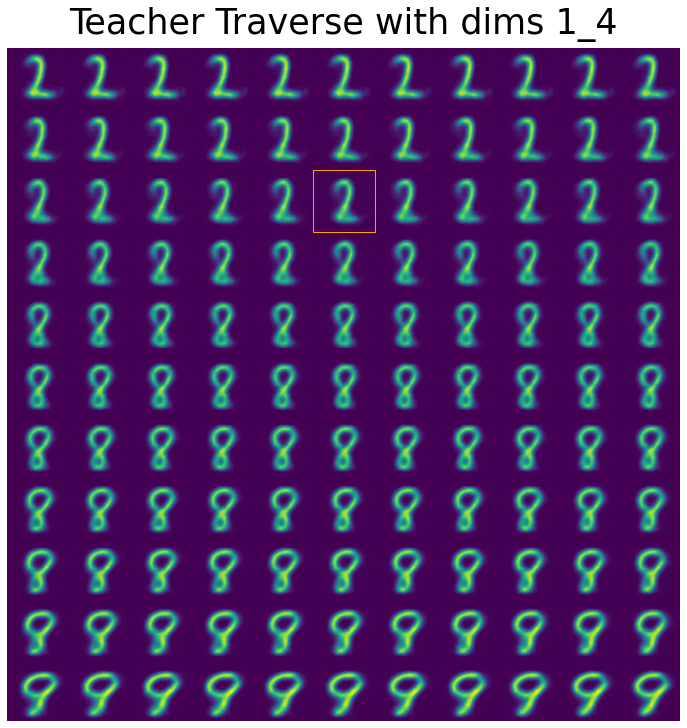

In [66]:
%matplotlib inline
trainer.traverse_latent(180, data_train, dim1=1, dim2=4)

In [ ]:
from scipy.stats import norm
trainer.__plot_settings__()

trainer.img_encoder.eval()
trainer.img_decoder.eval()

img_ind = 367
dim1 = 6
dim2 = 7
dataset = data_train
granularity = 11

if img_ind >= len(dataset):
    img_ind = np.random.randint(len(dataset))

data_y, data_x = dataset[img_ind]
data_y = data_y[np.newaxis, ...].to(torch.float32).to(trainer.teacher_args.device)

latent, z, mu, logvar = trainer.img_encoder(data_y)
z = z.squeeze()
e = z.cpu().detach().numpy().squeeze().tolist()
print(e[dim1], e[dim2])
grid_x = norm.ppf(np.linspace(0.05, 0.95, granularity))
grid_y = norm.ppf(np.linspace(0.05, 0.95, granularity))
print(grid_x, grid_y)

anchor1 = np.searchsorted(grid_x, e[dim1])
anchor2 = np.searchsorted(grid_y, e[dim2])
f = lambda x, g: x * 128 if x < g else (x - 1) * 128
anchor1, anchor2 = f(anchor1, granularity), f(anchor2, granularity)

figure = np.zeros((granularity * 128, granularity * 128))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z[dim1], z[dim2] = xi, yi
        output = trainer.img_decoder(z)
        figure[i * 128: (i + 1) * 128, j * 128: (j + 1) * 128] = output.cpu().detach().numpy().squeeze().tolist()

fig = plt.figure(constrained_layout=True)
fig.suptitle('Teacher Traverse with dims ' + str(dim1) + '_' + str(dim2))
plt.imshow(figure)
rect = plt.Rectangle((anchor1, anchor2), 128, 128, fill=False, edgecolor='orange', linewidth=2)
ax = plt.gca()
ax.add_patch(rect)
plt.axis('off')
plt.xlabel(str(dim1))
plt.ylabel(str(dim2))
plt.show()